In [1]:
!pip install torch_geometric -q

In [2]:
import pickle
with open('merged_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
loaded_data[0]

[[1, 3, 0, 7, 2, 9],
 [array([ 72,  94, 125,  34], dtype=int64),
  array([ 72, 125, 108,  97], dtype=int64),
  array([111, 227, 185,  51], dtype=int64),
  array([ 72, 168, 125, 128], dtype=int64),
  array([115, 202, 145, 171], dtype=int64),
  array([128,  48, 185,  26], dtype=int64)],
 [5, 5, 1, 7, 0, 4],
 [7, 1, 6, 7, 2, 2]]

In [3]:
# i=0
# for sublist in loaded_data_1:
#     loaded_data[i].append(sublist[3][:-1])
#     i+=1
#     if i==80788:
#         break

In [4]:
from collections import defaultdict, Counter
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import torch
import numpy as np
import pickle


class FloorplanGraphDataset(Dataset):
    def __init__(self, path, split=None):
        super(FloorplanGraphDataset, self).__init__()
        self.path = path
        with open(self.path, 'rb') as f:
            loaded_data = pickle.load(f)
        self.subgraphs = loaded_data
        self.subgraphs = self.filter_graphs(self.subgraphs)
        if split=='train':
            self.subgraphs = self.subgraphs[:120000]
        elif split=='test':
            self.subgraphs = self.subgraphs[120000:]    
        num_nodes = defaultdict(int)
        for g in self.subgraphs:
            labels = g[0] 
            if len(labels) > 0:
                num_nodes[len(labels)] += 1
        print(f'Number of graphs: {len(self.subgraphs)}')
        print(f'Number of graphs by rooms: {num_nodes}')
        
    def len(self):
        return len(self.subgraphs)

    def get(self, index, bbs=False):
        graph = self.subgraphs[index]
        labels = np.array(graph[0])
        vastu=np.array(graph[3])
        rooms_bbs = np.array(graph[1])
        orientation=graph[2]
        temp=rooms_bbs
#         edge2node = [item for sublist in graph[3] for item in sublist]
#         node_doors = np.array(edge2node)[graph[4]]
#         doors_count = Counter(node_doors)
        features = []
        rooms_bbs_new = []
        for i, bb in enumerate(rooms_bbs):
            x0, y0 = bb[0], bb[1]
            x1, y1 = bb[2], bb[3]
            #temp.append([x0,y0,x1,y1])
            xmin, ymin = min(x0, x1), min(y0, y1)
            xmax, ymax = max(x0, x1), max(y0, y1)
            l, b = xmax - xmin, ymax - ymin
            area = l*b
            if l<b:
                l, b = b, l
            features.append([area, l, b, 0, 0,orientation[i]]) 
            rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
        rooms_bbs = np.stack(rooms_bbs_new)
        intersect = self.intersect(rooms_bbs,rooms_bbs)
        for i in range(len(rooms_bbs)):
            for j in range(i+1,len(rooms_bbs)):
                if intersect[i,j]>0.7*intersect[j,j]:
                    if intersect[i,i]>intersect[j,j]: #is i a parent
                        features[i][4] = 1
                        features[j][3] = 1
                    else:   # i is child
                        features[i][3] = 1
                        features[j][4] = 1
                if intersect[i,j]>0.7*intersect[i,i]:
                    if intersect[j,j]>intersect[i,i]: 
                        features[j][4] = 1
                        features[i][3] = 1
                    else:
                        features[j][3] = 1
                        features[i][4] = 1

        rooms_bbs = rooms_bbs/256.0

        tl = np.min(rooms_bbs[:, :2], 0)
        br = np.max(rooms_bbs[:, 2:], 0)
        shift = (tl+br)/2.0 - 0.5
        rooms_bbs[:, :2] -= shift
        rooms_bbs[:, 2:] -= shift
        tl -= shift
        br -= shift
        edges = self.build_graph(rooms_bbs,temp) 
#         labels = labels - 1
#         labels[labels>=5] = labels[labels>=5] - 1
        x = torch.tensor(features, dtype=torch.float)
        edge_index = torch.tensor(edges.T, dtype=torch.long)
        y1 = torch.tensor(labels, dtype=torch.long) #y
        y2 = torch.tensor(vastu, dtype=torch.long) ##
        d = Data(x=x, edge_index=edge_index, y_1=y1, y_2=y2) #y=y
        if bbs:
            return d, rooms_bbs
        return d

    def build_graph(self, bbs,temp):
        edges = []
        for k in range(len(bbs)):
            for l in range(len(bbs)):
                if l > k:
                    bb0 = bbs[k]
                    bb1 = bbs[l]
                    #print(bbs,temp)
                    bb2 = temp[k]
                    bb3 = temp[l]
                    if self.is_adjacent(bb0, bb1) and  self.manhattam(bb2,bb3):
                        edges.append([k, l])
                        edges.append([l, k])
        edges = np.array(edges)
        return edges

    def filter_graphs(self, graphs):
        new_graphs = []
        for g in graphs:       
            labels = g[0]
            rooms_bbs = g[1]
            # discard broken samples
            check_none = np.sum([bb is None for bb in rooms_bbs])
            #check_node = np.sum([nd == 0 for nd in labels])
            if (len(labels) < 2) or (check_none > 0):
                continue
            new_graphs.append(g)
        return new_graphs

    def is_adjacent(self, box_a, box_b, threshold=0.03):
        
        x0, y0, x1, y1 = box_a
        x2, y2, x3, y3 = box_b

        h1, h2 = x1-x0, x3-x2
        w1, w2 = y1-y0, y3-y2

        xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
        yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0

        delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
        delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0

        delta = max(delta_x, delta_y)

        return delta < threshold

    def intersect(self, A,B):
        A, B = A[:,None], B[None]
        low = np.s_[...,:2]
        high = np.s_[...,2:]
        A,B = A.copy(),B.copy()
        A[high] += 1; B[high] += 1
        intrs = (np.maximum(0,np.minimum(A[high],B[high])
                            -np.maximum(A[low],B[low]))).prod(-1)
        return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)
    def manhattam(self,box_a, box_b):
        x0, y0, x1, y1 = box_a
        x2, y2, x3, y3 = box_b

        if x2>=x1 and y2<=y1:
            return False
        elif x2>=x1 and y3>=y0:
            return False
        elif x3<=x0 and y3>=y0:
            return False
        elif x3<=x0 and y2<=y1:
            return False
        else:
            return True

In [5]:
MOD_ROOM_CLASS = {0: "Living room", 
                1: "Master oom",
                2: "Kitchen",
                3: "Bathroom",
                4: "Dining room",
                5: "Child room",
                6: "Study room",
                7: "Second room",
                8: "Guest room",
                9: "Balcony",
                10: "Entrance",
                11: "Storage",
                12: "Wall-in"}
# def visualize(d, bbs=None):
#     G = to_networkx(d, to_undirected=True)
#     plt.figure(figsize=(7,7))
#     plt.axis('off')
#     labels = {i: MOD_ROOM_CLASS[int(d.y[i])] for i in range(len(d.y))}
#     c = plt.get_cmap('tab20').colors
#     color = [c[i] for i in d.y]
#     nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, labels=labels, node_color=color, cmap='Dark2')
#     plt.show()
#     if bbs is not None:
#         plt.figure(figsize=(7,7))
#         for i, (xmin, ymin, xmax, ymax) in enumerate(bbs):
#             rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='k', facecolor=c[d.y[i]], alpha=0.9)
#             plt.gca().add_patch(rect)
#         plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
#from dataset import MOD_ROOM_CLASS

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# def accuracy(model, dataloader):
#     correct = 0
#     num_nodes = 0
#     model.to(device)
#     model.eval()
#     for data in dataloader:
#         data = data.to(device)
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(1)
#         correct += sum(pred==data.y)
#         num_nodes += data.num_nodes
#     return (correct/num_nodes).item()
def accuracy(model, dataloader):
    correct = 0
    vastu_correct = 0
    num_nodes = 0
    model.to(device)
    model.eval()
    for data in dataloader:
        data = data.to(device)
        out, vastu_out = model(data.x, data.edge_index)
        pred = out.argmax(1)
        vastu_pred = vastu_out.argmax(1)
        correct += sum(pred == data.y_1)
        vastu_correct += sum(vastu_pred == data.y_2)
        num_nodes += data.num_nodes
    return (correct / num_nodes).item(), (vastu_correct / num_nodes).item()

In [7]:
device

device(type='cpu')

In [8]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(6, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier1 = Linear(16, 13) #self.classifier
        self.classifier2 = Linear(16, 8)##

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out_1 = self.classifier1(h) #out
        out_2 = self.classifier2(h) ##
        return out_1,out_2 #out

In [9]:
import torch
import numpy as np
#from dataset import FloorplanGraphDataset
#from utils import  accuracy
#from model import Model
from torch.nn import Linear
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, TAGConv
import pathlib
#import argparse

model_type = 'sage'  # 'mlp', 'gcn', 'gat', 'sage', 'tagcn'
hidden_layers = 2
num_epochs = 100
learning_rate = 0.004
step_size = 10
gamma = 0.8
batch_size = 128
outpath = 'results'
dataset_file = 'merged_data.pkl'
models = {
    'mlp': Linear,
    'gcn': GCNConv,
    'gat': GATConv,
    'sage': SAGEConv,
    'tagcn': TAGConv,
}
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

outpath = pathlib.Path(outpath) #
outpath.mkdir(parents=True, exist_ok=True) #

torch.manual_seed(42) #
model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
print(model)
model = model.to(device)

cpu
Model(
  (layer1): SAGEConv(6, 16, aggr=mean)
  (layer2): ModuleList(
    (0): SAGEConv(16, 16, aggr=mean)
  )
  (classifier1): Linear(in_features=16, out_features=13, bias=True)
  (classifier2): Linear(in_features=16, out_features=8, bias=True)
)


In [10]:
dataset = FloorplanGraphDataset(path=dataset_file, split=None)
train = [dataset[i].to(device) for i in range(65000)]
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
trainloader2 = DataLoader(train, batch_size=65000)
test = [dataset[i].to(device) for i in range(65000,80788)]
testloader = DataLoader(test, batch_size=15788)

Number of graphs: 80788
Number of graphs by rooms: defaultdict(<class 'int'>, {6: 25104, 7: 29278, 8: 20364, 5: 5788, 4: 254})


e:\Anaconda\envs\graph\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
dataset.get(2).x

tensor([[1.0260e+03, 3.8000e+01, 2.7000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.7050e+03, 5.5000e+01, 3.1000e+01, 0.0000e+00, 0.0000e+00, 7.0000e+00],
        [2.4840e+03, 5.4000e+01, 4.6000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00],
        [3.0080e+03, 6.4000e+01, 4.7000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+00],
        [2.7730e+03, 5.9000e+01, 4.7000e+01, 0.0000e+00, 0.0000e+00, 6.0000e+00],
        [9.5900e+03, 1.3700e+02, 7.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.7200e+02, 5.4000e+01, 1.8000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00]])

In [12]:
dataset.get(2).y_1

tensor([3, 2, 7, 1, 8, 0, 9])

In [13]:
num_epochs = num_epochs
lr = learning_rate
step_size = step_size
gamma = gamma
outpath = 'result'

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_ep = []
te_acc_ep = []
tr_acc_ep = []

In [34]:
for epoch in range(num_epochs):
    model.train()
    loss = 0
    for data in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        out, vastu_out = model(data.x, data.edge_index)
        loss_cls = criterion(out, data.y_1)
        loss_vastu = criterion(vastu_out, data.y_2)
        loss_ = loss_cls + loss_vastu
        loss_.backward()
        optimizer.step()
        loss += loss_.item()
    exp_lr_scheduler.step()
    loss /= len(train)
    tr_acc, tr_vastu_acc = accuracy(model, trainloader2)
    te_acc, te_vastu_acc = accuracy(model, testloader)
    loss_ep.append(loss)
    tr_acc_ep.append(tr_acc)
    te_acc_ep.append(te_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.10f}, Train Acc: {tr_acc:.6f}, Train Vastu Acc: {tr_vastu_acc:.6f}, Test Acc: {te_acc:.6f}, Test Vastu Acc: {te_vastu_acc:.6f}')

Epoch [1/100] Loss: 0.0246236140, Train Acc: 0.533016, Train Vastu Acc: 0.222502, Test Acc: 0.533090, Test Vastu Acc: 0.203493
Epoch [2/100] Loss: 0.0241965620, Train Acc: 0.573275, Train Vastu Acc: 0.231559, Test Acc: 0.567839, Test Vastu Acc: 0.213648
Epoch [3/100] Loss: 0.0237164736, Train Acc: 0.623512, Train Vastu Acc: 0.228993, Test Acc: 0.619374, Test Vastu Acc: 0.209514
Epoch [4/100] Loss: 0.0230937447, Train Acc: 0.641845, Train Vastu Acc: 0.238464, Test Acc: 0.631455, Test Vastu Acc: 0.218655
Epoch [5/100] Loss: 0.0228334109, Train Acc: 0.661741, Train Vastu Acc: 0.237914, Test Acc: 0.653127, Test Vastu Acc: 0.219585
Epoch [6/100] Loss: 0.0227507712, Train Acc: 0.673667, Train Vastu Acc: 0.235147, Test Acc: 0.661506, Test Vastu Acc: 0.216297
Epoch [7/100] Loss: 0.0224910974, Train Acc: 0.668936, Train Vastu Acc: 0.238797, Test Acc: 0.660539, Test Vastu Acc: 0.221726
Epoch [8/100] Loss: 0.0224438820, Train Acc: 0.690398, Train Vastu Acc: 0.240165, Test Acc: 0.678707, Test Vast

In [36]:
# Save the trained model
torch.save(model.state_dict(), 'SAGE_merged_trained_model.pth')

In [14]:
# Load the saved model
loaded_model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
loaded_model.load_state_dict(torch.load('SAGE_merged_trained_model.pth',map_location=torch.device('cpu')))
loaded_model.eval()

Model(
  (layer1): SAGEConv(6, 16, aggr=mean)
  (layer2): ModuleList(
    (0): SAGEConv(16, 16, aggr=mean)
  )
  (classifier1): Linear(in_features=16, out_features=13, bias=True)
  (classifier2): Linear(in_features=16, out_features=8, bias=True)
)

In [15]:
new_features=dataset.get(80000)

In [16]:
with torch.no_grad():
    x, edge_index = new_features.x, new_features.edge_index
    new_predictions, new_vastu_predictions = loaded_model(x, edge_index)

In [17]:
new_predictions

tensor([[-5.0253e+00, -2.7047e+00,  9.8556e+00,  7.9760e+00,  5.0289e+00,
          5.8819e+00,  7.7003e+00,  7.4888e+00,  3.8873e+00,  7.7263e+00,
          4.4570e+00,  3.9635e+00,  2.3653e+00],
        [ 1.3706e+01,  4.2007e+00,  3.8335e+00, -1.8499e+02,  5.6718e+00,
         -1.2025e+00, -3.6895e-01,  9.0068e-01, -1.8885e+02,  2.8514e+00,
         -3.2384e+02, -4.7872e+02, -8.6921e+01],
        [-3.9960e+00,  1.7561e+00,  6.9791e+00,  5.1074e+00,  3.5870e+00,
          5.1098e+00,  6.5196e+00,  7.8012e+00,  3.4654e+00,  1.5024e+00,
          6.9110e-01, -4.7082e-02, -1.0042e+00],
        [-7.4176e+00, -1.0780e+01,  1.0956e+01,  1.3333e+01,  4.1772e+00,
          4.2562e+00,  6.8978e+00,  4.5130e+00,  2.2246e+00,  9.7020e+00,
          6.0046e+00,  9.6865e+00,  8.6123e+00],
        [-1.1831e-01,  9.3941e+00,  1.7604e+00, -4.1182e+00,  5.2824e-01,
          2.9573e+00,  3.4126e+00,  7.3225e+00,  1.6103e+00, -3.6553e+00,
         -5.5165e+00, -9.8451e+00, -1.1031e+01],
        [-1.812

In [18]:
new_vastu_predictions

tensor([[ 8.2119,  5.8317,  5.1262,  2.0248,  8.4529,  6.8907, 11.5399, 12.6975],
        [ 1.3681,  6.1288,  9.4800,  3.1526, 20.6286, 25.7128, 16.9847, -5.2126],
        [ 7.1240,  6.4548,  0.5398, -1.7590,  6.4022,  4.4660,  8.3227, 10.1752],
        [10.9910,  8.7460, 10.5725, 10.9616, 11.1246, 10.9625,  9.8186,  6.9084],
        [ 0.6994,  1.5914, -1.9986, -3.5593, -0.5517, -0.0897,  1.5149,  2.9087],
        [ 2.4427,  1.8403,  1.7735,  1.6813,  1.8650,  2.8355,  1.9550,  1.2586],
        [10.5900, 11.7327, 13.9006, 13.3658,  9.4943, 10.8315, 10.2881,  6.9234]])

In [19]:
# For regular target label
predicted_categories = new_predictions.argmax(dim=1)
predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in predicted_categories]
predicted_room_categories

['Kitchen',
 'Living room',
 'Second room',
 'Bathroom',
 'Master oom',
 'Second room',
 'Balcony']

In [20]:
new_features.y_1

tensor([2, 0, 7, 3, 1, 6, 9])

In [21]:
predicted_vastu_categories = new_vastu_predictions.argmax(dim=1)
predicted_vastu_categories

tensor([7, 5, 7, 4, 7, 5, 2])

In [22]:
new_features.y_2

tensor([6, 5, 7, 3, 7, 5, 2])

#Over

In [32]:
for epoch in range(num_epochs):
    model.train()
    loss = 0
    for data in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        out, vastu_out = model(data.x, data.edge_index)
        loss_cls = criterion(out, data.y_1)
        loss_vastu = criterion(vastu_out, data.y_2)
        loss_ = loss_cls + loss_vastu
#         out = model(data.x, data.edge_index)
#         loss_ = criterion(out, data.y)
        loss_.backward()
        optimizer.step()
        loss += loss_.item()
    exp_lr_scheduler.step()
    loss/=len(train)
    tr_acc = accuracy(model, trainloader2)
    te_acc = accuracy(model, testloader)
    loss_ep.append(loss)
    tr_acc_ep.append(tr_acc)
    te_acc_ep.append(te_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.10f}, Train Acc: {tr_acc:.6f}, Train Vastu Acc: {tr_vastu_acc:.6f}, Test Acc: {te_acc:.6f}, Test Vastu Acc: {te_vastu_acc:.6f}')

TypeError: unsupported format string passed to tuple.__format__

In [112]:
result = np.array([loss_ep, tr_acc_ep, te_acc_ep]).T

In [113]:
np.savetxt(outpath+f'{type(model.layer1).__name__}{len(model.layer2)+1}_loss_tracc_teacc_{lr}_{num_epochs}_{step_size}_{gamma}.txt', result)

In [114]:
max_idx = result[:,2].argmax()

In [115]:
print(f'\nMax Test Accuracy at Epoch {max_idx+1}: {result[max_idx]}\n')


Max Test Accuracy at Epoch 97: [0.00435549 0.81698328 0.7991752 ]



In [116]:
# Save the trained model
torch.save(model.state_dict(), 'TAGCN_trained_model.pth')

In [117]:
# Load the saved model
loaded_model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
loaded_model.load_state_dict(torch.load('TAGCN_trained_model.pth'))
loaded_model.eval()

Model(
  (layer1): TAGConv(5, 16, K=3)
  (layer2): ModuleList(
    (0): TAGConv(16, 16, K=3)
  )
  (classifier): Linear(in_features=16, out_features=13, bias=True)
)

In [118]:
new_features=dataset.get(80000)

In [119]:
with torch.no_grad():
    x, edge_index = new_features.x, new_features.edge_index
    new_predictions = loaded_model(x, edge_index)

In [120]:
new_predictions

tensor([[-2.9376,  6.3781, 14.6895,  9.5600,  8.8523,  8.5527, 10.8334, 10.1885,
          7.1644, 12.3237,  7.2296,  6.1664,  4.4598],
        [33.2781, 20.8251, 14.1385,  9.3908, 16.5651,  7.3705,  4.7070, 10.8552,
          4.7827, 15.3252,  6.5340,  7.2608,  4.4075],
        [ 2.1363,  9.6933, 10.6665,  8.3447,  8.6590, 12.0974, 13.5733, 15.2446,
         10.7762,  8.8499,  6.0393,  6.6214,  5.5884],
        [-9.8012, -4.5129,  6.0286,  9.2822,  1.4477,  0.5968,  3.0171,  1.5725,
         -0.7760,  1.7699,  0.0854,  3.0912,  2.7258],
        [14.4867, 20.7796,  9.6600,  8.0665, 11.8248, 13.6965, 13.5025, 18.2429,
         12.2861, 11.1500,  9.1284, 10.7092,  9.1700],
        [ 6.2804, 15.5996, 13.4080,  8.8266, 11.6364, 13.1025, 14.2061, 16.5520,
         11.8731, 12.4833,  9.5257,  9.1138,  7.3093],
        [-2.0429,  3.5352,  7.6868,  9.0508,  3.6671,  1.5607,  3.1294,  2.4370,
         -0.5074, 10.1856,  3.4692,  6.1882,  5.2820]])

In [121]:
# Assuming new_predictions is your tensor
predicted_categories = new_predictions.argmax(dim=1)

# Now you have the indices of the predicted categories
# You can map these indices to the actual room categories using your MOD_ROOM_CLASS dictionary
predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in predicted_categories]
predicted_room_categories

['Kitchen',
 'Living room',
 'Second room',
 'Bathroom',
 'Master oom',
 'Second room',
 'Balcony']

# ***TESTING***

In [20]:
import pickle
#from torch_geometric.data import Data
with open('/kaggle/input/house-clean-data-rplan/clean_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [21]:
len(loaded_data)

80788

In [22]:
loaded_data[2]

[[3, 2, 7, 1, 8, 0, 9],
 [array([163, 232, 190, 194]),
  array([ 67, 232,  98, 177]),
  array([119,  90, 173,  44]),
  array([ 67, 108, 114,  44]),
  array([ 67, 172, 114, 113]),
  array([103, 232, 173,  95]),
  array([119,  39, 173,  21])],
 [1, 7, 4, 5, 6, 0, 4]]

In [141]:
index=7
graph = loaded_data[index]
labels = np.array(graph[0])
rooms_bbs = np.array(graph[1])
temp=rooms_bbs
# edge2node = [item for sublist in graph[3] for item in sublist]
# node_doors = np.array(edge2node)[graph[4]]
# doors_count = Counter(node_doors)
features = []
rooms_bbs_new = []

In [142]:
def intersect(A,B): #didn't read yet
    A, B = A[:,None], B[None]
    low = np.s_[...,:2]
    high = np.s_[...,2:]
    A,B = A.copy(),B.copy()
    A[high] += 1; B[high] += 1
    intrs = (np.maximum(0,np.minimum(A[high],B[high])
                        -np.maximum(A[low],B[low]))).prod(-1)
    return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)

In [143]:
for i, bb in enumerate(rooms_bbs):
    x0, y0 = bb[0], bb[1]
    x1, y1 = bb[2], bb[3]
    #for computation of length & breadth
    xmin, ymin = min(x0, x1), min(y0, y1)
    xmax, ymax = max(x0, x1), max(y0, y1)
    l, b = xmax - xmin, ymax - ymin
    area = l*b
    if l<b:
        l, b = b, l
    rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax])) #????
    features.append([area, l, b, 0, 0]) 
    #rooms_bbs = np.stack(rooms_bbs_new)
# intersect = intersect(rooms_bbs,rooms_bbs)

In [144]:
rooms_bbs_new

[array([ 41,  57,  88, 128]),
 array([ 41, 108,  71, 128]),
 array([ 74, 147, 113, 191]),
 array([ 56, 131,  71, 156]),
 array([154, 147, 178, 203]),
 array([181, 147, 216, 191]),
 array([ 91,  50, 148,  66]),
 array([ 74,  69, 195, 191])]

In [145]:
rooms_bbs = np.stack(rooms_bbs_new)
intersect = intersect(rooms_bbs,rooms_bbs)

In [146]:
intersect

array([[ 3456,   651,     0,     0,     0,     0,     0,   900],
       [  651,   651,     0,     0,     0,     0,     0,     0],
       [    0,     0,  1800,     0,     0,     0,     0,  1800],
       [    0,     0,     0,   416,     0,     0,     0,     0],
       [    0,     0,     0,     0,  1425,     0,     0,  1125],
       [    0,     0,     0,     0,     0,  1620,     0,   675],
       [    0,     0,     0,     0,     0,     0,   986,     0],
       [  900,     0,  1800,     0,  1125,   675,     0, 15006]])

In [147]:
for i in range(len(rooms_bbs)): #able to understand the logic
    for j in range(i+1,len(rooms_bbs)):
        if intersect[i,j]>0.7*intersect[j,j]:
            if intersect[i,i]>intersect[j,j]: #is i a parent
                features[i][4] = 1
                features[j][3] = 1
            else:   # i is child
                features[i][3] = 1
                features[j][4] = 1
        if intersect[i,j]>0.7*intersect[i,i]:
            if intersect[j,j]>intersect[i,i]: 
                features[j][4] = 1
                features[i][3] = 1
            else:
                features[j][3] = 1
                features[i][4] = 1

rooms_bbs = rooms_bbs/256.0

In [148]:
tl = np.min(rooms_bbs[:, :2], 0)
br = np.max(rooms_bbs[:, 2:], 0)
shift = (tl+br)/2.0 - 0.5
shift

array([ 0.00195312, -0.00585938])

In [149]:
def is_adjacent(box_a, box_b, threshold=0.03):
        
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b

    h1, h2 = x1-x0, x3-x2
    w1, w2 = y1-y0, y3-y2
#     if h1<w1:
#         h1,w1=w1,h1
#     if h2<w2:
#         h2,w2=w2,h2

    xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
    yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0

    delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
    delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0

    delta = max(delta_x, delta_y)
    print(delta)
    print(delta<threshold)
    return delta < threshold

In [150]:
def manhattam(box_a, box_b):
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    
    if x2>=x1 and y2<=y1:
        return False
    elif x2>=x1 and y3>=y0:
        return False
    elif x3<=x0 and y3>=y0:
        return False
    elif x3<=x0 and y2<=y1:
        return False
    else:
        return True

In [151]:
 def build_graph(bbs):
    edges = []
    for k in range(len(bbs)):
        for l in range(len(bbs)):
            if l > k:
                bb0 = bbs[k]
                bb1 = bbs[l]
                bb2 = temp[k]
                bb3 = temp[l]
                print(k,l)
                #print(bb0,bb1)
                if is_adjacent(bb0, bb1) and  manhattam(bb2,bb3):
                    print("Adj",k,l)
                    edges.append([k, l])
                    edges.append([l, k])
    edges = np.array(edges)
    return edges

In [152]:
import torch
# tl = np.min(rooms_bbs[:, :2], 0)
# br = np.max(rooms_bbs[:, 2:], 0)
# shift = (tl+br)/2.0 - 0.5
# rooms_bbs[:, :2] -= shift
# rooms_bbs[:, 2:] -= shift
# tl -= shift
# br -= shift
edges = build_graph(rooms_bbs) 
print(edges)
# labels = labels - 1
# labels[labels>=5] = labels[labels>=5] - 1
x = torch.tensor(features, dtype=torch.float)
edge_index = torch.tensor(edges.T, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.long)
d = Data(x=x, edge_index=edge_index, y=y)
# if bbs:
#     print(d, rooms_bbs)
print(d)
#[1, 5, 7, 2, 3, 9, 0]

0 1
-0.078125
True
Adj 0 1
0 2
0.07421875
False
0 3
0.01171875
True
Adj 0 3
0 4
0.2578125
False
0 5
0.36328125
False
0 6
0.01171875
True
Adj 0 6
0 7
-0.0546875
True
Adj 0 7
1 2
0.07421875
False
1 3
0.01171875
True
Adj 1 3
1 4
0.32421875
False
1 5
0.4296875
False
1 6
0.1640625
False
1 7
0.01171875
True
Adj 1 7
2 3
0.01171875
True
Adj 2 3
2 4
0.16015625
False
2 5
0.265625
False
2 6
0.31640625
False
2 7
-0.15234375
True
Adj 2 7
3 4
0.32421875
False
3 5
0.4296875
False
3 6
0.25390625
False
3 7
0.01171875
True
Adj 3 7
4 5
0.01171875
True
Adj 4 5
4 6
0.31640625
False
4 7
-0.16015625
True
Adj 4 7
5 6
0.31640625
False
5 7
-0.0546875
True
Adj 5 7
6 7
0.01171875
True
Adj 6 7
[[0 1]
 [1 0]
 [0 3]
 [3 0]
 [0 6]
 [6 0]
 [0 7]
 [7 0]
 [1 3]
 [3 1]
 [1 7]
 [7 1]
 [2 3]
 [3 2]
 [2 7]
 [7 2]
 [3 7]
 [7 3]
 [4 5]
 [5 4]
 [4 7]
 [7 4]
 [5 7]
 [7 5]
 [6 7]
 [7 6]]
Data(x=[8, 5], edge_index=[2, 26], y=[8])


In [172]:
edges

array([[0, 1],
       [1, 0],
       [0, 5],
       [5, 0],
       [0, 6],
       [6, 0],
       [1, 2],
       [2, 1],
       [1, 5],
       [5, 1],
       [1, 6],
       [6, 1],
       [2, 6],
       [6, 2],
       [3, 4],
       [4, 3],
       [3, 6],
       [6, 3],
       [4, 6],
       [6, 4]])

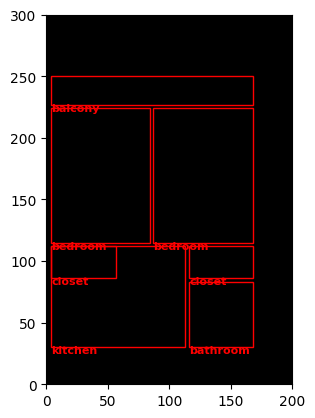

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a blank image
image = np.zeros((256, 256, 3), dtype=np.uint8)

# Create figure and axes
fig, ax = plt.subplots()

# Display the blank image
ax.imshow(image)

# Define the bounding boxes
bounding_boxes = [
    [4, 30, 113, 112],
    [116, 30, 168, 83],
    [4, 86, 57, 112],
    [116, 86, 168, 112],
    [4, 115, 84, 224],
    [87, 115, 168, 224],
    [4, 227, 168, 250]
]

# Define room categories
room_categories = {
    1: "living_room",
    2: "kitchen",
    3: "bedroom",
    4: "bathroom",
    5: "missing",
    6: "closet",
    7: "balcony",
    8: "corridor",
    9: "dining_room",
    10: "laundry_room"
}

# Define room categories for each bounding box
bounding_box_categories = [2.0, 4.0, 6.0, 6.0, 3.0, 3.0, 7.0]

# Add bounding boxes to the image
for bbox, category in zip(bounding_boxes, bounding_box_categories):
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    # Add room category label
    room_category = room_categories[int(category)]
    ax.text(x, y-5, room_category, fontsize=8, color='r', weight='bold')

# Set axis limits to match the image dimensions
ax.set_xlim(0, image.shape[1])
ax.set_ylim(0, image.shape[0])

# Show plot
plt.show()


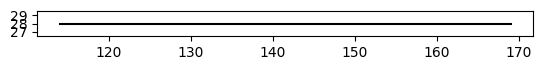

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Wall coordinates
wall_coordinates = [
   # [2, 251, 169, 251, 7, 0],
   #  [169, 28, 169, 84, 0, 4],
   #  [58, 84, 58, 113, 2, 6],
     [114, 28, 169, 28, 0, 4],
   #  [85, 113, 114, 113, 2, 3],
   #  [2, 28, 114, 28, 0, 2],
#     [114, 28, 114, 84, 4, 2],
#     [85, 113, 85, 225, 3, 3],
#     [2, 28, 2, 84, 2, 0],
#     [169, 84, 169, 113, 0, 6],
#     [169, 113, 169, 225, 0, 3],
#     [169, 225, 169, 251, 0, 7],
#     [58, 113, 85, 113, 2, 3],
#     [114, 113, 169, 113, 6, 3],
#     [85, 225, 169, 225, 3, 7],
#     [114, 84, 169, 84, 4, 6],
#     [2, 84, 58, 84, 2, 6],
#     [2, 113, 58, 113, 6, 3],
#     [2, 225, 85, 225, 3, 7],
#     [114, 84, 114, 113, 6, 2],
#     [2, 84, 2, 113, 6, 0],
#     [2, 113, 2, 225, 3, 0],
  #  [2, 225, 2, 251, 7, 0]
]

# Create figure and axis
fig, ax = plt.subplots()

# Plot wall segments
for segment in wall_coordinates:
    x1, y1, x2, y2, _, _ = segment
    ax.plot([x1, x2], [y1, y2], color='black')

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Show plot
plt.show()


In [5]:
check_none = np.sum([bb is None for bb in loaded_array[0][1]])
print(check_none)

0


In [10]:
num_nodes = defaultdict(int)
num_nodes

defaultdict(int, {})

In [12]:
edge2node = [item for sublist in loaded_array[0][3] for item in sublist]
print(edge2node)

[1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 1]


In [13]:
node_doors = np.array(edge2node)[loaded_array[0][4]]
print(node_doors)

[2 0 2 1 1]


In [24]:
doors_count=Counter(node_doors)

In [25]:
features = []
rooms_bbs_new = []
for i, bb in enumerate(loaded_array[0][1]):
    x0, y0 = bb[0], bb[1]
    x1, y1 = bb[2], bb[3]
    xmin, ymin = min(x0, x1), min(y0, y1)
    xmax, ymax = max(x0, x1), max(y0, y1)
    l, b = xmax - xmin, ymax - ymin
    area = l*b
    if l<b:
        l, b = b, l
    features.append([area, l, b, doors_count[i], 0, 0]) 
    rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
rooms_bbs = np.stack(rooms_bbs_new)

In [32]:
rooms_bbs

array([[132,   6, 148,  65],
       [110,  68, 208, 130],
       [132,  91, 160, 130]])

In [33]:
rooms_bbs[:,None]

array([[[132,   6, 148,  65]],

       [[110,  68, 208, 130]],

       [[132,  91, 160, 130]]])

In [34]:
rooms_bbs[None]

array([[[132,   6, 148,  65],
        [110,  68, 208, 130],
        [132,  91, 160, 130]]])

In [ ]:
visualize(dataset.get(78678))

In [ ]:
dataset = FloorplanGraphDataset(path=dataset_file, split=None)

In [ ]:
train = [dataset[i].to(device) for i in range(120000)]

In [ ]:
train

In [ ]:
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [ ]:
trainloader

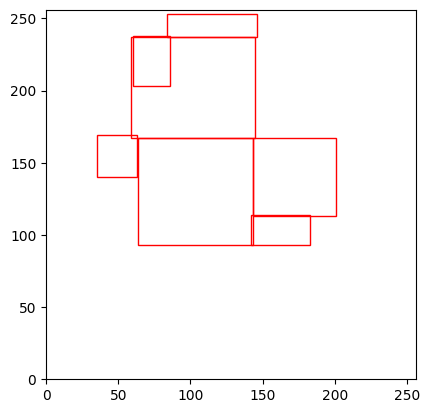

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the rectangles
rectangles = [(64, 89, 143, 163), (59, 19, 145, 89), (60, 18, 86, 53), (84, 3, 146, 19), (143, 89, 201, 143), (142, 142, 183, 163), (35, 87, 63, 116)]
rectangles = [[x, 256 - y1, x2, 256 - y2] for x, y1, x2, y2 in rectangles]
# Create figure and axis
fig, ax = plt.subplots()

# Set limits
ax.set_xlim(0, 256)
ax.set_ylim(0, 256)

# Add rectangles to the plot
for rect in rectangles:
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], linewidth=1, edgecolor='r', facecolor='none'))
ax.set_aspect('equal')
# Display the plot
plt.show()


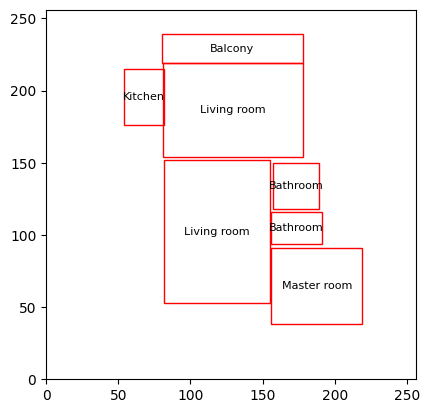

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the rectangles
rectangles = [(64, 89, 143, 163), (59, 19, 145, 89), (60, 18, 86, 53), (84, 3, 146, 19), (143, 89, 201, 143), (142, 142, 183, 163), (35, 87, 63, 116)]
rectangles = [[x, 256 - y1, x2, 256 - y2] for x, y1, x2, y2 in rectangles]

# Define the labels
labels = ['Living room',
 'Balcony',
 'Kitchen',
 'Living room',
 'Bathroom',
 'Bathroom',
 'Master room']

# Create figure and axis
fig, ax = plt.subplots()

# Set limits
ax.set_xlim(0, 256)
ax.set_ylim(0, 256)

# Add rectangles to the plot
for rect, label in zip(rectangles, labels):
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], linewidth=1, edgecolor='r', facecolor='none'))
    # Calculate center coordinates of the rectangle
    center_x = (rect[0] + rect[2]) / 2
    center_y = (rect[1] + rect[3]) / 2
    # Add label at the center
    ax.text(center_x, center_y, label, fontsize=8, color='black', ha='center', va='center')  # Center the text

ax.set_aspect('equal')
# Display the plot
plt.show()


In [3]:
!pip install torch_geometric -q

In [4]:
from collections import defaultdict, Counter
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import torch
import numpy as np
import pickle

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch_geometric.utils import to_networkx
import networkx as nx

In [6]:
import torch
import numpy as np
#from dataset import FloorplanGraphDataset
#from utils import  accuracy
#from model import Model
from torch.nn import Linear
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, TAGConv
import pathlib

In [7]:
def intersect(A,B):
    A, B = A[:,None], B[None]
    low = np.s_[...,:2]
    high = np.s_[...,2:]
    A,B = A.copy(),B.copy()
    A[high] += 1; B[high] += 1
    intrs = (np.maximum(0,np.minimum(A[high],B[high])
                        -np.maximum(A[low],B[low]))).prod(-1)
    return intrs #/ ((A[high]-A[low]).prod(-1)+(B[high]-B[low]).prod(-1)-intrs)

def build_graph(bbs,temp):
    edges = []
    for k in range(len(bbs)):
        for l in range(len(bbs)):
            if l > k:
                bb0 = bbs[k]
                bb1 = bbs[l]
                #print(bbs,temp)
                bb2 = temp[k]
                bb3 = temp[l]
                if is_adjacent(bb0, bb1) and  manhattam(bb2,bb3):
                    edges.append([k, l])
                    edges.append([l, k])
    edges = np.array(edges)
    return edges

def is_adjacent(box_a, box_b, threshold=0.03):
        
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    h1, h2 = x1-x0, x3-x2
    w1, w2 = y1-y0, y3-y2
    xc1, xc2 = (x0+x1)/2.0, (x2+x3)/2.0
    yc1, yc2 = (y0+y1)/2.0, (y2+y3)/2.0
    delta_x = np.abs(xc2-xc1) - (h1 + h2)/2.0
    delta_y = np.abs(yc2-yc1) - (w1 + w2)/2.0
    delta = max(delta_x, delta_y)
    return delta < threshold

def manhattam(box_a, box_b):
    x0, y0, x1, y1 = box_a
    x2, y2, x3, y3 = box_b
    if x2>=x1 and y2<=y1:
        return False
    elif x2>=x1 and y3>=y0:
        return False
    elif x3<=x0 and y3>=y0:
        return False
    elif x3<=x0 and y2<=y1:
        return False
    else:
        return True
rooms_bbs = np.array(rectangles)
temp=rooms_bbs
features = []
rooms_bbs_new = []
for i, bb in enumerate(rooms_bbs):
    x0, y0 = bb[0], bb[1]
    x1, y1 = bb[2], bb[3]
    #temp.append([x0,y0,x1,y1])
    xmin, ymin = min(x0, x1), min(y0, y1)
    xmax, ymax = max(x0, x1), max(y0, y1)
    l, b = xmax - xmin, ymax - ymin
    area = l*b
    if l<b:
        l, b = b, l
    features.append([area, l, b, 0, 0]) 
    rooms_bbs_new.append(np.array([xmin, ymin, xmax, ymax]))
rooms_bbs = np.stack(rooms_bbs_new)
intersect = intersect(rooms_bbs,rooms_bbs)
for i in range(len(rooms_bbs)):
    for j in range(i+1,len(rooms_bbs)):
        if intersect[i,j]>0.7*intersect[j,j]:
            if intersect[i,i]>intersect[j,j]: #is i a parent
                features[i][4] = 1
                features[j][3] = 1
            else:   # i is child
                features[i][3] = 1
                features[j][4] = 1
        if intersect[i,j]>0.7*intersect[i,i]:
            if intersect[j,j]>intersect[i,i]: 
                features[j][4] = 1
                features[i][3] = 1
            else:
                features[j][3] = 1
                features[i][4] = 1

rooms_bbs = rooms_bbs/256.0
tl = np.min(rooms_bbs[:, :2], 0)
br = np.max(rooms_bbs[:, 2:], 0)
shift = (tl+br)/2.0 - 0.5
rooms_bbs[:, :2] -= shift
rooms_bbs[:, 2:] -= shift
tl -= shift
br -= shift
edges = build_graph(rooms_bbs,temp) 
#         labels = labels - 1
#         labels[labels>=5] = labels[labels>=5] - 1
x = torch.tensor(features, dtype=torch.float)
edge_index = torch.tensor(edges.T, dtype=torch.long)
#y = torch.tensor(labels, dtype=torch.long)
d = Data(x=x, edge_index=edge_index)
print(d)

Data(x=[7, 5], edge_index=[2, 20])


In [8]:
d.x

tensor([[5.8460e+03, 7.9000e+01, 7.4000e+01, 0.0000e+00, 0.0000e+00],
        [6.0200e+03, 8.6000e+01, 7.0000e+01, 0.0000e+00, 1.0000e+00],
        [9.1000e+02, 3.5000e+01, 2.6000e+01, 1.0000e+00, 0.0000e+00],
        [9.9200e+02, 6.2000e+01, 1.6000e+01, 0.0000e+00, 0.0000e+00],
        [3.1320e+03, 5.8000e+01, 5.4000e+01, 0.0000e+00, 0.0000e+00],
        [8.6100e+02, 4.1000e+01, 2.1000e+01, 0.0000e+00, 0.0000e+00],
        [8.1200e+02, 2.9000e+01, 2.8000e+01, 0.0000e+00, 0.0000e+00]])

In [9]:
d.edge_index

tensor([[0, 1, 0, 4, 0, 5, 0, 6, 1, 2, 1, 3, 1, 4, 1, 6, 2, 3, 4, 5],
        [1, 0, 4, 0, 5, 0, 6, 0, 2, 1, 3, 1, 4, 1, 6, 1, 3, 2, 5, 4]])

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
class Model(torch.nn.Module):

    def __init__(self, layer_type, n_hidden=2):
        super(Model, self).__init__()
        torch.manual_seed(42)
        self.is_mlp = True if layer_type.__name__=='Linear' else False
        self.layer1 = layer_type(5, 16)
        self.layer2 = torch.nn.ModuleList()
        for _ in range(n_hidden-1):
            self.layer2.append(layer_type(16,16))
        self.classifier = Linear(16, 13)

    def forward(self, x, edge_index):
        h = self.layer1(x) if self.is_mlp else self.layer1(x, edge_index)
        h = F.relu(h)
        for layer in self.layer2:
            h = layer(h) if self.is_mlp else layer(h, edge_index)
            h = F.relu(h)
        out = self.classifier(h)
        return out

In [11]:
models = {
    'mlp': Linear,
    'gcn': GCNConv,
    'gat': GATConv,
    'sage': SAGEConv,
    'tagcn': TAGConv,
}
model_type = 'tagcn'
hidden_layers = 2

In [12]:
# Load the saved model
loaded_model = Model(layer_type=models[model_type], n_hidden=hidden_layers)
loaded_model.load_state_dict(torch.load('trained_model.pth',map_location=torch.device('cpu')))
loaded_model.eval()

Model(
  (layer1): TAGConv(5, 16, K=3)
  (layer2): ModuleList(
    (0): TAGConv(16, 16, K=3)
  )
  (classifier): Linear(in_features=16, out_features=13, bias=True)
)

In [13]:
with torch.no_grad():
    x, edge_index = d.x, d.edge_index
    new_predictions = loaded_model(x, edge_index)

In [14]:
new_predictions

tensor([[21.3441, 21.1586, 16.2172, 10.6944, 17.0636, 12.3662, 12.8749, 16.0431,
         11.4612, 12.5013, 13.0968, 12.2507,  9.4332],
        [25.9159, 22.8395, 18.6913, 11.5983, 19.7111, 13.1354, 13.6319, 16.8961,
         12.3843, 13.0991, 14.8099, 13.2504,  9.9741],
        [-2.8864, -2.8350,  9.6000,  9.1008,  4.4796,  5.0676,  7.4776,  6.4219,
          3.7146,  5.3249,  2.3823,  3.6164,  2.8289],
        [-3.2107,  4.1034, 12.5081,  9.8509,  5.3607,  6.5815,  9.0524,  7.1822,
          4.7999, 16.5897,  7.4755,  8.1224,  6.9062],
        [10.6014, 18.8031, 13.4018,  7.6726, 12.5591, 15.1775, 15.9190, 19.2220,
         13.8619, 11.9739,  8.8578,  7.8355,  6.0262],
        [-7.7145, -2.2982,  7.6110,  8.8997,  1.6581,  3.3895,  5.8243,  4.0767,
          1.7079,  9.4964,  2.9945,  5.2428,  4.7394],
        [-7.9442, -6.9682,  5.6833,  8.7136,  0.7563,  1.6533,  4.1046,  2.5531,
          0.2051,  3.2659,  0.1574,  2.9967,  2.7501]])

In [17]:
import torch
import torch.nn.functional as F

In [27]:
# Define the threshold for selecting classes
threshold = 0.1

# Apply the softmax function to the logits to get probabilities
probs = F.softmax(new_predictions, dim=1)

In [28]:
probs

tensor([[5.3870e-01, 4.4746e-01, 3.1971e-03, 1.2771e-05, 7.4532e-03, 6.7961e-05,
         1.1303e-04, 2.6861e-03, 2.7493e-05, 7.7794e-05, 1.4111e-04, 6.0549e-05,
         3.6180e-06],
        [9.5326e-01, 4.3972e-02, 6.9441e-04, 5.7699e-07, 1.9254e-03, 2.6836e-06,
         4.4091e-06, 1.1534e-04, 1.2663e-06, 2.5881e-06, 1.4320e-05, 3.0107e-06,
         1.1371e-07],
        [2.0915e-06, 2.2016e-06, 5.5364e-01, 3.3606e-01, 3.3072e-03, 5.9544e-03,
         6.6296e-02, 2.3067e-02, 1.5389e-03, 7.7009e-03, 4.0608e-04, 1.3950e-03,
         6.3471e-04],
        [2.4692e-09, 3.7071e-06, 1.6563e-02, 1.1618e-03, 1.3034e-05, 4.4183e-05,
         5.2284e-04, 8.0563e-05, 7.4393e-06, 9.8123e-01, 1.0802e-04, 2.0628e-04,
         6.1134e-05],
        [1.0474e-04, 3.8198e-01, 1.7230e-03, 5.5995e-06, 7.4184e-04, 1.0174e-02,
         2.1356e-02, 5.8075e-01, 2.7298e-03, 4.1322e-04, 1.8318e-05, 6.5900e-06,
         1.0793e-06],
        [1.9054e-08, 4.2880e-06, 8.6253e-02, 3.1293e-01, 2.2412e-04, 1.2659e-03,

In [29]:
result=[]
for i, p in enumerate(probs):
    temp=[]
    for ind,j in enumerate(p):
        if(j>threshold):
            temp.append(ind)
    result.append(temp)

In [30]:
result

[[0, 1], [0], [2, 3], [9], [1, 7], [3, 9], [3]]

In [38]:
def generate_combinations(arrays, current=[], index=0):
    if index == len(arrays):
        print(current)
        return

    for element in arrays[index]:
        generate_combinations(arrays, current + [element], index + 1)

arrays = [[0, 1], [0], [2, 3], [9], [1, 7], [3, 9], [3]]
generate_combinations(arrays)

[0, 0, 2, 9, 1, 3, 3]
[0, 0, 2, 9, 1, 9, 3]
[0, 0, 2, 9, 7, 3, 3]
[0, 0, 2, 9, 7, 9, 3]
[0, 0, 3, 9, 1, 3, 3]
[0, 0, 3, 9, 1, 9, 3]
[0, 0, 3, 9, 7, 3, 3]
[0, 0, 3, 9, 7, 9, 3]
[1, 0, 2, 9, 1, 3, 3]
[1, 0, 2, 9, 1, 9, 3]
[1, 0, 2, 9, 7, 3, 3]
[1, 0, 2, 9, 7, 9, 3]
[1, 0, 3, 9, 1, 3, 3]
[1, 0, 3, 9, 1, 9, 3]
[1, 0, 3, 9, 7, 3, 3]
[1, 0, 3, 9, 7, 9, 3]


In [15]:
MOD_ROOM_CLASS = {0: "Living room", 
                1: "Master room",
                2: "Kitchen",
                3: "Bathroom",
                4: "Dining room",
                5: "Child room",
                6: "Study room",
                7: "Second room",
                8: "Guest room",
                9: "Balcony",
                10: "Entrance",
                11: "Storage",
                12: "Wall-in"}

In [16]:
# Assuming new_predictions is your tensor
predicted_categories = new_predictions.argmax(dim=1)
print(np.array(predicted_categories))

# Now you have the indices of the predicted categories
# You can map these indices to the actual room categories using your MOD_ROOM_CLASS dictionary
predicted_room_categories = [MOD_ROOM_CLASS[idx.item()] for idx in predicted_categories]
predicted_room_categories

[0 0 2 9 7 9 3]


['Living room',
 'Living room',
 'Kitchen',
 'Balcony',
 'Second room',
 'Balcony',
 'Bathroom']

In [73]:
def visualize(d, bbs=None):
    G = to_networkx(d, to_undirected=True)
    plt.figure(figsize=(7,7))
    plt.axis('off')
    labels = {i: MOD_ROOM_CLASS[int(np.array(predicted_categories)[i])] for i in range(len(np.array(predicted_categories)))}
    c = plt.get_cmap('tab20').colors
    color = [c[i] for i in np.array(predicted_categories)]

    # Get positions of nodes from the floorplan data
    positions = {i: ((rectangles[i][0]+rectangles[i][2])/2, (rectangles[i][1]+rectangles[i][3])/2) for i in range(len(rectangles))}
    nx.draw_networkx(G, pos=positions, with_labels=True, labels=labels, node_color=color, cmap='Dark2')
    plt.show()

    if bbs is not None:
        plt.figure(figsize=(7,7))
        for i, (xmin, ymin, xmax, ymax) in enumerate(bbs):
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='k', facecolor=c[np.array(predicted_categories)[i]], alpha=0.9)
            plt.gca().add_patch(rect)
        plt.axis('off')
        plt.show()


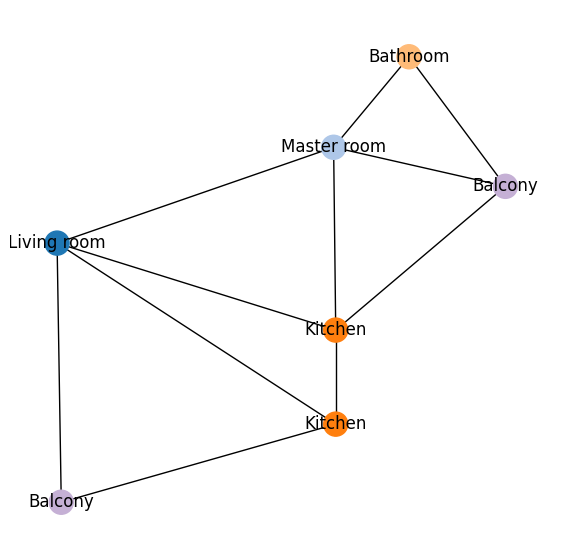

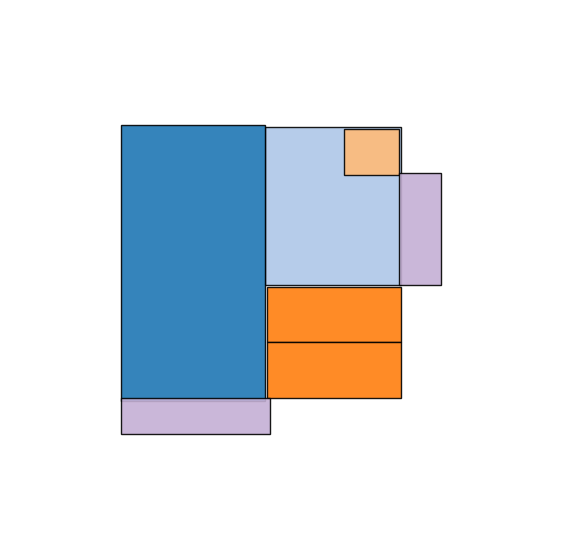

In [74]:
visualize(d,rooms_bbs)

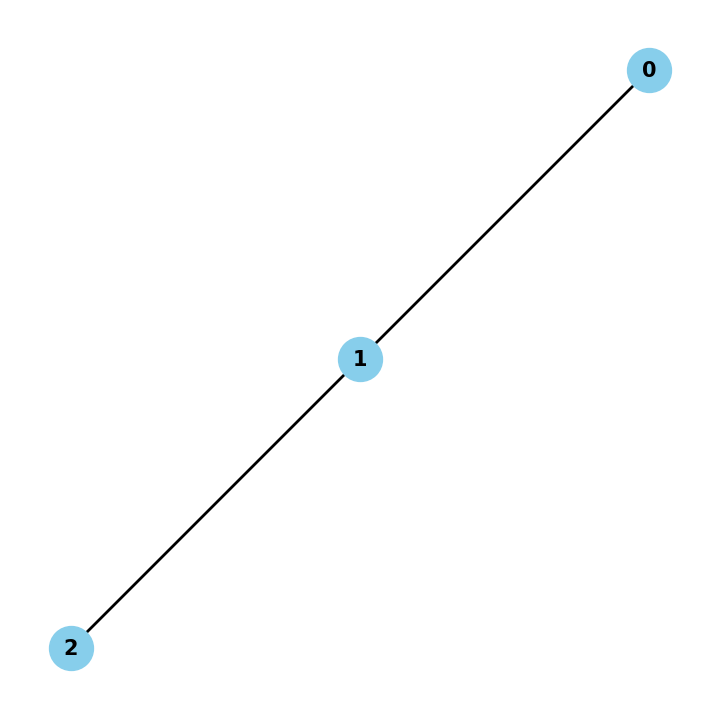

In [28]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

# Create a simple graph
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

# Convert to NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
edges = data.edge_index.t().tolist()
G.add_edges_from(edges)

# Visualize the graph
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G)  # Layout the nodes using spring layout algorithm
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, font_size=15, font_weight='bold', width=2)
plt.show()
